In [1]:
import os 
import time
import copy

import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f'''using device {device}''')

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pickle
import random 
import pandas as pd

using device cuda:0


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
def usecuda(input):
    if torch.cuda.is_available(): return input.cuda()
    return input

In [4]:
path = !pwd
path = path[0]
print(path)

/home/r2/Documents/RNNexp


In [5]:
# data = pd.read_pickle(path+"/data/step3_DAT_MT_USDJPY_M1_2018_merged_pickled") 
# data.head()

### functions

In [6]:
class Struct():
    pass 

def load_trumpdata(datapath):
    import json 
    tweets, tweet_str = [], ''
    filenames = ['condensed_2018.json', 'condensed_2016.json', 'condensed_2017.json', 'condensed_2018.json']
    for fname in filenames:
        f = open(datapath+fname,"r")
        data = f.readline()
        f.close()
        data_tr = json.loads(data)
        for line in range(0,len(data_tr)):
            tweet = '*' + data_tr[line]["text"].rstrip('\\') + '€'
            tweets.append(tweet)
            tweet_str = tweet_str + tweet            
    symbols = list(set(tweet_str))
    decoder = {idx: symbols[idx] for idx in range(0,len(symbols))}
    encoder = {symbols[idx]: idx for idx in range(0,len(symbols))}        
    return tweets, tweet_str, decoder, encoder

def pp_trumpdata(filename, prop, bsize=1):
    Data, train, valid, test = Struct(), Struct(), Struct(), Struct()        
    tweets, tweet_str, Data.decoder, Data.encoder = load_trumpdata(filename)    

    train.tweets = tweets[0:round(prop[0]*len(tweets))]
    train.tweet_str = tweet_str[0:round(prop[1]*len(tweet_str))]    
    valid.tweets = tweets[round(prop[0]*len(tweets)):round(prop[1]*len(tweets))]
    valid.tweet_str = tweet_str[round(prop[0]*len(tweet_str)):round(prop[1]*len(tweet_str))]    
    test.tweets  = tweets[round(prop[1]*len(tweets)):-1]
    test.tweet_str  = tweet_str[round(prop[1]*len(tweet_str)):-1]    


    train.batch_str = []
    stepsize = round(len(train.tweet_str)/bsize-1)
    for i in range(0,bsize):
        train.batch_str.append(train.tweet_str[i*stepsize:(i+1)*stepsize])

    Data.train, Data.valid, Data.test, Data.bsize = train, valid, test, bsize
    return Data

def onehencode(symbol, encoder):
    x = torch.zeros(len(encoder),1)
    x[encoder[symbol]] = 1.0
    return usecuda(x.t())

def encodestr(string, encoder, seq_len):
    x = torch.zeros((seq_len,len(encoder)))
    x[[idx for idx in range(0,seq_len)],[encoder[char] for char in string]] = 1
    return usecuda(x.reshape(x.shape[0],1,x.shape[1]))

def generate_seq(model, hidden, symbol, seq_len, m, seed):
    with torch.no_grad():
        result_str = symbol
        for i in range(seq_len):
            x = onehencode(symbol,encoder)
            output, new_hidden = model.forward(x,hidden)
        
            hidden = new_hidden.detach()
            prob = np.exp(output.detach().data.cpu().numpy())
            cum_prob = np.cumsum(prob)

            a = random.random()
            idx = np.where(cum_prob - a > 0)[0][0]
            symbol = decoder[idx]
            result_str += symbol

        return result_str
    
def save_checkpoint(state, filename='models/checkpoint.pth.tar'):
    torch.save(state, filename)

def load_checkpoint(filename='models/checkpoint.pth.tar'):
    checkpoint = torch.load(filename)    
    for item in iter(checkpoint):
        print(item)
    model = RNN(checkpoint['in_sz'],checkpoint['hd_sz'],checkpoint['out_sz'])
    model.load_state_dict(checkpoint['state_dict'])
    #     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, epoch, loss    

def get_valid_loss(data_valid, seq_len):
    start = time.time()
    i, e, itters = 0, 0, 1000 
    loss_valid = 0
    hidden = usecuda(torch.zeros(1,rnn.hd_sz))
    while i < itters:
        Xvalid, Yvalid = generate_input(e,seq_len,data_valid.tweet_str)
        loss, hidden   = train(Xvalid,Yvalid,hidden,base_lr,use_opt) 
        loss_valid += loss
        i += 1
        e += seq_len + 1
    print(f"calculating validation loss took {time.time()-start:.2f} seconds")
    return loss_valid/itters

def train_batch(model,X,Y,hidden,lr,use_opt):
    if use_opt: optimizer.zero_grad() 
    else: model.zero_grad()
    loss = 0
    for char in range(X.size()[1]):
        x = X[:,char,:].reshape(X.shape[0],X.shape[2])
        output, hidden = model.forward(x,hidden)
        y = Y[:,char,:]
        loss += criterion(output,y.reshape(Params.bsize))
    loss.backward()
    if use_opt: optimizer.step()
    else:
        for p in model.parameters(): p.data.add_(-lr, p.grad.data)

    return loss/(X.size()[0]*X.size()[2]), hidden.detach()

def generate_batch(e, Data, seq_len):
    X = torch.zeros(Data.bsize,seq_len,len(Data.encoder))
    Y = torch.zeros(Data.bsize,seq_len,1)
    for i in range(0,Data.bsize):        
        x = encodestr(Data.train.batch_str[i][e:e+seq_len],Data.encoder,seq_len)
        y = torch.Tensor([Data.encoder[char] for char in Data.train.batch_str[i][e+1:e+seq_len+1]])
        X[i,:,:] = x.reshape(seq_len,len(Data.encoder))
        Y[i,:,:] = y.reshape(seq_len,1)
    return usecuda(X),usecuda(Y.long())

## my RNN module

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__()
        self.hd_sz  = hidden_size
        self.in_sz  = input_size
        self.out_sz = output_size
        
        self.h1 = nn.Linear(input_size + hidden_size, hidden_size)        
        self.o1 = nn.Linear(input_size + hidden_size, input_size)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = torch.tanh(self.h1(combined))
        output = self.o1(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(hidden_layers[0])

### code

In [8]:
Data1 = pp_trumpdata(path+"/data/trump/", [0.9,0.95], 1)
Data2 = pp_trumpdata(path+"/data/trump/", [0.9,0.95], 5)

In [23]:
Params = Struct()
Params.hidden_sz  = 150
Params.input_sz   = len(Data1.encoder)
Params.seq_len    = 30
Params.intv_print = 200
Params.intv_plot  = 100
Params.epoches    = 1
Params.itters     = 10000
Params.use_opt    = True 
Params.lr         = 0.0005
Params.bsize      = 1

In [24]:
def do_training(model,Data,Params,Plots=0):
    if Plots==0:
        Plots = Struct()
        Plots.loss_train, Plots.loss_valid = [], []
#     optimizer  = optim.RMSprop(model.parameters(), lr=Params.lr)
    start      = time.time()
    loss_train = 0
    hidden     = usecuda(torch.zeros(Params.bsize,model.hd_sz))
    for epoch in range(Params.epoches):
        char_idx = 0
        i = 0 
        while i < Params.itters:
            X,Y          = generate_batch(char_idx, Data, Params.seq_len)
            loss, hidden = train_batch(model,X,Y,hidden,Params.lr,True)
            loss_train  += loss
            if i%Params.intv_print == 0:
                print(loss_train/Params.intv_print)                
            if i%Params.intv_plot  == 0:  
                Plots.loss_train.append(loss_train/Params.intv_plot)
                loss_train = 0 
            char_idx += Params.seq_len + 1
            i        += 1
        print(f"""\n epoch {epoch+1} took {time.time() - start:.2f} seconds""")  
    return Plots

In [25]:
torch.manual_seed(24)
rnn1 = usecuda(RNN(Params.input_sz, Params.hidden_sz, 1))
torch.manual_seed(24)
rnn2 = usecuda(RNN(Params.input_sz, Params.hidden_sz, 1))

criterion = nn.NLLLoss()

optimizer = optim.RMSprop(rnn1.parameters(), lr=Params.lr)
# optimizer2 = optim.RMSprop(rnn2.parameters(), lr=Params.lr)

Plots1 = do_training(rnn1,Data1,Params)


tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2801, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2767, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2655, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2676, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2589, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2539, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2490, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2546, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2506, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2392, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2425, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2372, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2325, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2419, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2359, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2253, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2277, device='cuda:0', grad_fn=<DivBack

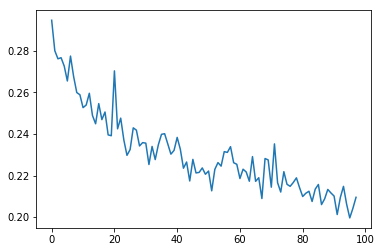

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(Plots1.loss_train[1:-1])

In [ ]:
save_checkpoint({
            'epoch': epoch,
            'arch': "1_RNN",
            'state_dict': rnn.state_dict(),
            'hd_sz': rnn.hd_sz,
            'in_sz': rnn.in_sz,
            'out_sz': rnn.out_sz,
            'loss': loss,
            'best_prec1': None,
            'optimizer' : None,
        })

In [ ]:
rnn2, epoch, loss = load_checkpoint(filename='models/checkpoint.pth.tar')
rnn2.cuda()

In [ ]:
print(generate_seq(rnn2, torch.zeros(1,hsize).cuda(),'T',100,m,42))
print(generate_seq(rnn, torch.zeros(1,hsize).cuda(),'T',100,m,42))

### build RNN network with LSTM

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__()
        self.hidden_sizes = hidden_size
        self.in_size      = input_size
        self.out_size     = output_size
        
        self.h1 = nn.Linear(input_size + hidden_size, hidden_size)        
        self.o1 = nn.Linear(input_size + hidden_size, input_size)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = torch.tanh(self.h1(combined))
        output = self.o1(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(hidden_layers[0])


### cut input into seq length bits

In [ ]:
data = data[['Open','High','Low','Close']]

In [ ]:
cutoff = 0.2
set_train = data[0:round(len(data)*cutoff)]
set_test  = data[round(len(data)*cutoff):-1]

In [ ]:
# set_train.head()

In [ ]:
input_sz = set_train.shape[1]
hidden_sz = 100
output_sz = 1

In [ ]:
rnn = RNN(input_sz, hidden_sz, output_sz)

In [ ]:
# for index, row in set_train.iterrows():
#     print(np.array(row))

In [ ]:
lr = 0.005

def train(X,Y)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(X.size()[0]):
        output, hidden = rnn(X[i], hidden)
        
    loss = criterion(output, )